In [1]:
%matplotlib inline
from matplotlib import style
style.use('fivethirtyeight')
import matplotlib.pyplot as plt
from scipy import stats
from numpy import mean
import pprint

In [2]:
import numpy as np
import pandas as pd

In [3]:
import datetime as dt

# Reflect Tables into SQLAlchemy ORM

In [4]:
# Python SQL toolkit and Object Relational Mapper
import sqlalchemy
from sqlalchemy.ext.automap import automap_base
from sqlalchemy.orm import Session
from sqlalchemy import create_engine, func, inspect, distinct

In [5]:
engine = create_engine("sqlite:///Resources/hawaii.sqlite")

In [6]:
# reflect an existing database into a new model
Base = automap_base()
# reflect the tables
Base.prepare(engine, reflect=True)

In [7]:
# We can view all of the classes that automap found
Base.classes.keys()

['measurement', 'station']

In [8]:
# Save references to each table
Measurement = Base.classes.measurement
Station = Base.classes.station

In [9]:
# Create our session (link) from Python to the DB
session = Session(engine)

# Exploratory Climate Analysis

In [10]:
inspector = inspect(engine)
Measurement_columns = inspector.get_columns('Measurement')
Station_columns = inspector.get_columns('Station')
for c in Measurement_columns:
    print(c['name'], c["type"])
for c in Station_columns:
    print(c['name'], c["type"])

id INTEGER
station TEXT
date TEXT
prcp FLOAT
tobs FLOAT
id INTEGER
station TEXT
name TEXT
latitude FLOAT
longitude FLOAT
elevation FLOAT


### Design a query to retrieve the last 12 months of precipitation data and plot the results

In [11]:
# Calculate the date 1 year ago from the last data point in the database
last_day = session.query(Measurement.date).order_by(Measurement.date.desc()).first()
print(last_day)
last_day_last_year = dt.date(2017, 8, 23) - dt.timedelta(days=365)
print(last_day_last_year)

('2017-08-23',)
2016-08-23


In [12]:
# Perform a query to retrieve the data and precipitation scores

One_year_prcp = session.query(Measurement.date, Measurement.prcp).filter(Measurement.date > last_day_last_year).all() 

#One_year_prcp

#for row in One_year_prcp:
#    print(row._asdict(),',')


In [13]:
# Save the query results as a Pandas DataFrame and set the index to the date column
# Sort the dataframe by date
One_year_prcp_df = pd.DataFrame(One_year_prcp, columns=['date', 'prcp'])
One_year_prcp_df.sort_values('date', inplace=True, ascending=True)
One_year_prcp_df.set_index('date', inplace=True)
#One_year_prcp_df.dtypes
One_year_prcp_df

,prcp
date,
2016-08-24,0.08
2016-08-24,NaN
2016-08-24,2.15
2016-08-24,2.28
2016-08-24,2.15
...,...
2017-08-22,0.00
2017-08-23,0.08
2017-08-23,0.00


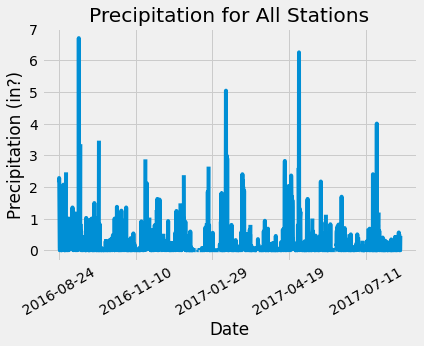

<Figure size 432x288 with 0 Axes>

In [45]:
# Use Pandas Plotting with Matplotlib to plot the data
#Hint for this week's homework: when creating the bar graph for the climate analysis 
#the imported style is broken if you use .bar in your plotting. 
#So instead of df.plot.bar(...), use df.plot(...). 
#This does not apply to the .hist plot further down the assignment.
ax = One_year_prcp_df.plot(title="Precipitation for All Stations", rot=30, legend=False)
ax.set_ylabel("Precipitation (in?)")
ax.set_xlabel("Date")
plt.show()
plt.savefig("Precipitation_all_stations.png")

###Assorted questions

In [15]:
# Use Pandas to calculate the summary statistics for the precipitation data
One_year_prcp_df.describe()

,prcp
count,2015.000000
mean,0.176462
std,0.460288
min,0.000000
25%,0.000000
50%,0.020000
75%,0.130000
max,6.700000


In [16]:
# Design a query to show how many stations are available in this dataset?
stations = session.query(Station.station).count()
print(stations)

#Double check:
#stations = session.query(Station.station).all()
#print(stations)

9


In [17]:
# What are the most active stations? (i.e. what stations have the most rows)?
# List the stations and the counts in descending order.

station_activity =  session.query(Measurement.station, func.count(Measurement.id)).\
    group_by(Measurement.station).\
    order_by(func.count(Measurement.id).desc()).\
    all()

station_activity

[('USC00519281', 2772),
 ('USC00519397', 2724),
 ('USC00513117', 2709),
 ('USC00519523', 2669),
 ('USC00516128', 2612),
 ('USC00514830', 2202),
 ('USC00511918', 1979),
 ('USC00517948', 1372),
 ('USC00518838', 511)]

In [18]:
#Checking that maximum activity is at the same station for different observations
station_temp_activity =  session.query(Measurement.station, func.count(Measurement.tobs)).\
    group_by(Measurement.station).\
    order_by(func.count(Measurement.tobs).desc()).\
    all()

station_temp_activity

[('USC00519281', 2772),
 ('USC00519397', 2724),
 ('USC00513117', 2709),
 ('USC00519523', 2669),
 ('USC00516128', 2612),
 ('USC00514830', 2202),
 ('USC00511918', 1979),
 ('USC00517948', 1372),
 ('USC00518838', 511)]

In [19]:
#Checking that maximum activity is at the same station for different observations

station_prcp_activity =  session.query(Measurement.station, func.count(Measurement.prcp)).\
    group_by(Measurement.station).\
    order_by(func.count(Measurement.prcp).desc()).\
    all()

station_prcp_activity


[('USC00519281', 2772),
 ('USC00513117', 2696),
 ('USC00519397', 2685),
 ('USC00519523', 2572),
 ('USC00516128', 2484),
 ('USC00514830', 1937),
 ('USC00511918', 1932),
 ('USC00517948', 683),
 ('USC00518838', 342)]

In [20]:
# Using the station id from the previous query, calculate the lowest temperature recorded, 
# highest temperature recorded, and average temperature of the most active station?
#Thanks to Monica T. James of the internet for a quicker way of doing this! I think I will delete my ugly method.
busiest_station = station_prcp_activity[0][0]
busiest_station
session.query(func.min(Measurement.tobs), func.avg(Measurement.tobs),\
              func.max(Measurement.tobs)).filter(Measurement.station == busiest_station).all()

[(54.0, 71.66378066378067, 85.0)]

In [34]:
# Choose the station with the highest number of temperature observations.
# Query the last 12 months of temperature observation data for this station
# Make dictionary for later

busiest_station_tobs = session.query(Measurement.date, Measurement.tobs).filter(Measurement.date > last_day_last_year).filter(Measurement.station==busiest_station).all() 

busiest_station_tobs

busiest_station_tobs_df = pd.DataFrame(busiest_station_tobs, columns=['date', 'tobs'])
busiest_station_tobs_df.sort_values('date', inplace=True, ascending=True)

busiest_station_tobs_dict = busiest_station_tobs_df.to_dict('records')
busiest_station_tobs_dict

[{'date': '2016-08-24', 'tobs': 77.0},
 {'date': '2016-08-25', 'tobs': 80.0},
 {'date': '2016-08-26', 'tobs': 80.0},
 {'date': '2016-08-27', 'tobs': 75.0},
 {'date': '2016-08-28', 'tobs': 73.0},
 {'date': '2016-08-29', 'tobs': 78.0},
 {'date': '2016-08-30', 'tobs': 77.0},
 {'date': '2016-08-31', 'tobs': 78.0},
 {'date': '2016-09-01', 'tobs': 80.0},
 {'date': '2016-09-02', 'tobs': 80.0},
 {'date': '2016-09-03', 'tobs': 78.0},
 {'date': '2016-09-04', 'tobs': 78.0},
 {'date': '2016-09-05', 'tobs': 78.0},
 {'date': '2016-09-06', 'tobs': 73.0},
 {'date': '2016-09-07', 'tobs': 74.0},
 {'date': '2016-09-08', 'tobs': 80.0},
 {'date': '2016-09-09', 'tobs': 79.0},
 {'date': '2016-09-10', 'tobs': 77.0},
 {'date': '2016-09-11', 'tobs': 80.0},
 {'date': '2016-09-12', 'tobs': 76.0},
 {'date': '2016-09-13', 'tobs': 79.0},
 {'date': '2016-09-14', 'tobs': 75.0},
 {'date': '2016-09-15', 'tobs': 79.0},
 {'date': '2016-09-16', 'tobs': 78.0},
 {'date': '2016-09-17', 'tobs': 79.0},
 {'date': '2016-09-18', '

In [62]:
#Convert darn thing to actual dictionary?
#new_busiest_tobs=dict()
#for ud in busiest_station_tobs_dict:
#     new_busiest_tobs[ud.pop('date')] = ud 

#new_busiest_tobs

#result = {k: v for d in busiest_station_tobs_dict for k, v in d.items()} 
#result
#from functools import reduce
#result = reduce(lambda d, src: d.update(src) or d, busiest_station_tobs_dict, {})
#result
#busiest_station_tobs

busiest_station_tobs_dict_default = busiest_station_tobs_df.to_dict()
busiest_station_tobs_dict_default

{'tobs': {'2016-08-24': 77.0,
  '2016-08-25': 80.0,
  '2016-08-26': 80.0,
  '2016-08-27': 75.0,
  '2016-08-28': 73.0,
  '2016-08-29': 78.0,
  '2016-08-30': 77.0,
  '2016-08-31': 78.0,
  '2016-09-01': 80.0,
  '2016-09-02': 80.0,
  '2016-09-03': 78.0,
  '2016-09-04': 78.0,
  '2016-09-05': 78.0,
  '2016-09-06': 73.0,
  '2016-09-07': 74.0,
  '2016-09-08': 80.0,
  '2016-09-09': 79.0,
  '2016-09-10': 77.0,
  '2016-09-11': 80.0,
  '2016-09-12': 76.0,
  '2016-09-13': 79.0,
  '2016-09-14': 75.0,
  '2016-09-15': 79.0,
  '2016-09-16': 78.0,
  '2016-09-17': 79.0,
  '2016-09-18': 78.0,
  '2016-09-19': 78.0,
  '2016-09-20': 76.0,
  '2016-09-21': 74.0,
  '2016-09-22': 77.0,
  '2016-09-23': 78.0,
  '2016-09-24': 79.0,
  '2016-09-25': 79.0,
  '2016-09-26': 77.0,
  '2016-09-27': 80.0,
  '2016-09-28': 78.0,
  '2016-09-29': 78.0,
  '2016-09-30': 78.0,
  '2016-10-01': 77.0,
  '2016-10-02': 79.0,
  '2016-10-03': 79.0,
  '2016-10-04': 79.0,
  '2016-10-05': 79.0,
  '2016-10-06': 75.0,
  '2016-10-07': 76.0,
  

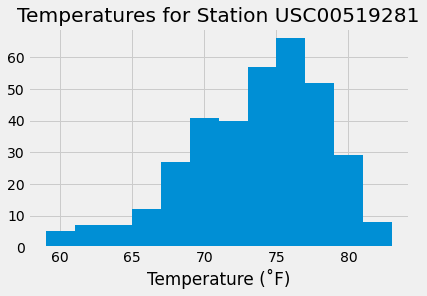

<Figure size 432x288 with 0 Axes>

In [35]:
# Plot the results as a histogram (n.b. if this doesn't work, first rerun preceding cell)
busiest_station_tobs_df.set_index('date', inplace=True)
busiest_station_tobs_df

busiest_station_tobs_df.hist(bins=12)
plt.tight_layout()
plt.title(f"Temperatures for Station {busiest_station}")
plt.xlabel("Temperature (˚F)")
plt.show()
plt.savefig("Busiest_station_temps.png")


In [49]:
# Using the the station with the highest number of temperature (and prcp) observations:
# Query the last 12 months of prcp observation data for this station
# Make prcp dictionary for later
busiest_station_prcp = session.query(Measurement.date, Measurement.prcp).filter(Measurement.date > last_day_last_year).filter(Measurement.station=='USC00519281').all() 

busiest_station_prcp

busiest_station_prcp_df = pd.DataFrame(busiest_station_prcp, columns=['date', 'prcp'])
busiest_station_prcp_df.sort_values('date', inplace=True, ascending=True)

busiest_station_prcp_dict = busiest_station_prcp_df.to_dict('records')
busiest_station_prcp_dict

[{'date': '2016-08-24', 'prcp': 2.15},
 {'date': '2016-08-25', 'prcp': 0.06},
 {'date': '2016-08-26', 'prcp': 0.01},
 {'date': '2016-08-27', 'prcp': 0.12},
 {'date': '2016-08-28', 'prcp': 0.6},
 {'date': '2016-08-29', 'prcp': 0.35},
 {'date': '2016-08-30', 'prcp': 0.0},
 {'date': '2016-08-31', 'prcp': 0.24},
 {'date': '2016-09-01', 'prcp': 0.02},
 {'date': '2016-09-02', 'prcp': 0.01},
 {'date': '2016-09-03', 'prcp': 0.12},
 {'date': '2016-09-04', 'prcp': 0.14},
 {'date': '2016-09-05', 'prcp': 0.03},
 {'date': '2016-09-06', 'prcp': 0.11},
 {'date': '2016-09-07', 'prcp': 0.16},
 {'date': '2016-09-08', 'prcp': 0.07},
 {'date': '2016-09-09', 'prcp': 0.16},
 {'date': '2016-09-10', 'prcp': 0.09},
 {'date': '2016-09-11', 'prcp': 0.3},
 {'date': '2016-09-12', 'prcp': 0.31},
 {'date': '2016-09-13', 'prcp': 0.34},
 {'date': '2016-09-14', 'prcp': 2.33},
 {'date': '2016-09-15', 'prcp': 0.83},
 {'date': '2016-09-16', 'prcp': 0.06},
 {'date': '2016-09-17', 'prcp': 0.36},
 {'date': '2016-09-18', 'prc

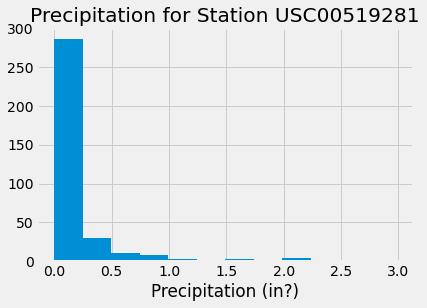

<Figure size 432x288 with 0 Axes>

In [50]:
# Plot the results as a histogram (n.b. if this doesn't work, first rerun preceding cell)
busiest_station_prcp_df.set_index('date', inplace=True)
busiest_station_prcp_df.dtypes
busiest_station_prcp_df

busiest_station_prcp_df.hist(bins=12)
plt.title(f"Precipitation for Station {busiest_station}")
plt.xlabel("Precipitation (in?)")
plt.tight_layout()
plt.show()
plt.savefig("Busiest_station_prcp.png")

In [ ]:
#IF NEED DIFF LABELS...
#Get dictionary of precipitation results for busiest station
#busiest_station_prcp_dict=[]
#for row in busiest_station_prcp:
#    busiest_station_prcp_dict.append(row)
#pp = pprint.PrettyPrinter(indent=4)
#pp.pprint(busiest_station_prcp_dict)

In [ ]:
#IF NEED DIFF LABELS...
#Get dictionary of temperature results for busiest station
#busiest_station_tobs_dict=[]
#for row in busiest_station_tobs:
#    busiest_station_tobs_dict.append(row)
#pp = pprint.PrettyPrinter(indent=4)
#pp.pprint(busiest_station_tobs_dict)

In [54]:
#Get dictionary of stations

#id INTEGER
#station TEXT
#name TEXT
#latitude FLOAT
#longitude FLOAT
#elevation FLOAT
stations_for_dict = session.query(Station.id, Station.station, Station.name, Station.latitude, Station.longitude, Station.elevation).all() 
stations_for_dict_df = pd.DataFrame(stations_for_dict, columns=['id', 'station', 'name', 'latitude', 'longitude', 'elevation'])
#stations_for_dict_df.sort_values('date', inplace=True, ascending=True)

stations_dict = stations_for_dict_df.to_dict('records')
stations_dict

[{'id': 1,
  'station': 'USC00519397',
  'name': 'WAIKIKI 717.2, HI US',
  'latitude': 21.2716,
  'longitude': -157.8168,
  'elevation': 3.0},
 {'id': 2,
  'station': 'USC00513117',
  'name': 'KANEOHE 838.1, HI US',
  'latitude': 21.4234,
  'longitude': -157.8015,
  'elevation': 14.6},
 {'id': 3,
  'station': 'USC00514830',
  'name': 'KUALOA RANCH HEADQUARTERS 886.9, HI US',
  'latitude': 21.5213,
  'longitude': -157.8374,
  'elevation': 7.0},
 {'id': 4,
  'station': 'USC00517948',
  'name': 'PEARL CITY, HI US',
  'latitude': 21.3934,
  'longitude': -157.9751,
  'elevation': 11.9},
 {'id': 5,
  'station': 'USC00518838',
  'name': 'UPPER WAHIAWA 874.3, HI US',
  'latitude': 21.4992,
  'longitude': -158.0111,
  'elevation': 306.6},
 {'id': 6,
  'station': 'USC00519523',
  'name': 'WAIMANALO EXPERIMENTAL FARM, HI US',
  'latitude': 21.33556,
  'longitude': -157.71139,
  'elevation': 19.5},
 {'id': 7,
  'station': 'USC00519281',
  'name': 'WAIHEE 837.5, HI US',
  'latitude': 21.45167,
  'l

In [ ]:
`/api/v1.0/<start>` and `/api/v1.0/<start>/<end>`

  * Return a JSON list of the minimum temperature, the average temperature, and the max temperature for a given start or start-end range.


In [ ]:
* When given the start only, calculate `TMIN`, `TAVG`, and `TMAX` for all dates greater than and equal to the start date.

In [ ]:
When given the start and the end date, calculate the `TMIN`, `TAVG`, and `TMAX` for dates between the start and end date inclusive.

In [ ]:
@app.route("/api/v1.0/justice-league/real_name/<real_name>")
def justice_league_by_real_name(real_name):
    """Fetch the Justice League character whose real_name matches
       the path variable supplied by the user, or a 404 if not."""

    canonicalized = real_name.replace(" ", "").lower()
    for character in justice_league_members:
        search_term = character["real_name"].replace(" ", "").lower()

        if search_term == canonicalized:
            return jsonify(character)

    return jsonify({"error": f"Character with real_name {real_name} not found."}), 404

In [ ]:
from flask import Flask, request
 from datetime import datetime

 app = Flask(__name__)

 @app.route('/')
 def home():
     return """
         <html><body>
             <h2>Welcome to the Greeter</h2>
             <form action="/greet">
                 What's your name? <input type='text' name='username'><br>
                 What's your favorite food? <input type='text' name='favfood'><br>
                 <input type='submit' value='Continue'>
             </form>
         </body></html>
         """

 @app.route('/greet')
 def greet():
     username = request.args.get('username', 'World')
     favfood = request.args['favfood']
     if favfood == '':
         msg = 'You did not tell me your favorite food.'
     else:
         msg = 'I like ' + favfood + ', too.'

     return """
         <html><body>
             <h2>Hello, {0}!</h2>
             {1}
         </body></html>
         """.format(username, msg)

 # Launch the FlaskPy dev server
 app.run(host="localhost", debug=True)


## Bonus Challenge Assignment

In [ ]:
# This function called `calc_temps` will accept start date and end date in the format '%Y-%m-%d' 
# and return the minimum, average, and maximum temperatures for that range of dates
def calc_temps(start_date, end_date):
    """TMIN, TAVG, and TMAX for a list of dates.
    
    Args:
        start_date (string): A date string in the format %Y-%m-%d
        end_date (string): A date string in the format %Y-%m-%d
        
    Returns:
        TMIN, TAVE, and TMAX
    """
    
    return session.query(func.min(Measurement.tobs), func.avg(Measurement.tobs), func.max(Measurement.tobs)).\
        filter(Measurement.date >= start_date).filter(Measurement.date <= end_date).all()

# function usage example
print(calc_temps('2012-02-28', '2012-03-05'))

In [ ]:
# Use your previous function `calc_temps` to calculate the tmin, tavg, and tmax 
# for your trip using the previous year's data for those same dates.


In [ ]:
# Plot the results from your previous query as a bar chart. 
# Use "Trip Avg Temp" as your Title
# Use the average temperature for the y value
# Use the peak-to-peak (tmax-tmin) value as the y error bar (yerr)


In [ ]:
# Calculate the total amount of rainfall per weather station for your trip dates using the previous year's matching dates.
# Sort this in descending order by precipitation amount and list the station, name, latitude, longitude, and elevation



In [ ]:
# Create a query that will calculate the daily normals 
# (i.e. the averages for tmin, tmax, and tavg for all historic data matching a specific month and day)

def daily_normals(date):
    """Daily Normals.
    
    Args:
        date (str): A date string in the format '%m-%d'
        
    Returns:
        A list of tuples containing the daily normals, tmin, tavg, and tmax
    
    """
    
    sel = [func.min(Measurement.tobs), func.avg(Measurement.tobs), func.max(Measurement.tobs)]
    return session.query(*sel).filter(func.strftime("%m-%d", Measurement.date) == date).all()
    
daily_normals("01-01")

In [ ]:
# calculate the daily normals for your trip
# push each tuple of calculations into a list called `normals`

# Set the start and end date of the trip

# Use the start and end date to create a range of dates

# Stip off the year and save a list of %m-%d strings

# Loop through the list of %m-%d strings and calculate the normals for each date


In [ ]:
# Load the previous query results into a Pandas DataFrame and add the `trip_dates` range as the `date` index


In [ ]:
# Plot the daily normals as an area plot with `stacked=False`
